# Finetuning IndoBERT for Essay Grading (Regression)

This notebook finetunes IndoBERT for Automated Essay Scoring (AES) using a regression approach.
The model takes a `question` and an `answer` as input and predicts a `score`.

## Key Features:
- **Regression**: The model predicts a continuous score.
- **Normalization**: Scores (0-10) are normalized to [0, 1] during training for stability.
- **Metrics**: 
    - MSE (Mean Squared Error)
    - Pearson Correlation
    - Spearman Rank Correlation
    - Quadratic Weighted Kappa (QWK) - The gold standard for AES.

In [1]:
import os, sys

# Only change directory if we are currently in the 'examples' directory
# This prevents the path from becoming incorrect if the cell is run multiple times
if os.getcwd().endswith('examples'):
    os.chdir('../')

# Add the current directory (project root) to sys.path
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

print(f"Current Working Directory: {os.getcwd()}")

import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, cohen_kappa_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler

Current Working Directory: d:\coding\python\indonlu


d:\coding\python\indonlu\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
###
# Common Functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.4f}'.format(key, value))
    return ' '.join(string_list)

# Set random seed
set_seed(26092020)

# Dataset & DataLoader

We define `EssayDataset` to load the CSVs and normalize the scores.

In [3]:
class EssayDataset(Dataset):
    def __init__(self, path, tokenizer, max_seq_len=512, lowercase=True):
        self.data = pd.read_csv(path)
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        self.lowercase = lowercase
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        question = str(row['question'])
        answer = str(row['answer'])
        score = float(row['score'])
        
        # Normalize score (0-10) -> (0-1)
        normalized_score = score / 10.0
        
        if self.lowercase:
            question = question.lower()
            answer = answer.lower()
            
        # Encode inputs
        # We concatenate Question and Answer with [SEP]
        encoded_inputs = self.tokenizer.encode_plus(
            question,
            answer,
            max_length=self.max_seq_len,
            padding='max_length',
            truncation='only_second',
            return_token_type_ids=True
        )
        
        input_ids = encoded_inputs['input_ids']
        token_type_ids = encoded_inputs['token_type_ids']
        attention_mask = encoded_inputs['attention_mask']
        
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(normalized_score, dtype=torch.float),
            'raw_score': score
        }

In [4]:
class EssayDataLoader(DataLoader):
    def __init__(self, dataset, batch_size=8, num_workers=0, shuffle=True):
        super().__init__(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            collate_fn=self.collate_fn
        )
        
    def collate_fn(self, batch):
        input_ids = torch.stack([item['input_ids'] for item in batch])
        token_type_ids = torch.stack([item['token_type_ids'] for item in batch])
        attention_mask = torch.stack([item['attention_mask'] for item in batch])
        labels = torch.stack([item['labels'] for item in batch])
        raw_scores = [item['raw_score'] for item in batch]
        
        return input_ids, token_type_ids, attention_mask, labels, raw_scores

# Load Model & Tokenizer

In [5]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p2')

config.num_labels = 1

model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2', config=config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: GPU not detected. Training will be slow on CPU.")

model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
GPU Name: NVIDIA GeForce RTX 2050


In [6]:
count_param(model)

124442113

# Prepare Data

In [7]:
train_path = './dataset/essai/train_preprocess.csv'
valid_path = './dataset/essai/valid_preprocess.csv'
test_path = './dataset/essai/test_preprocess.csv'

train_dataset = EssayDataset(train_path, tokenizer)
valid_dataset = EssayDataset(valid_path, tokenizer)
test_dataset = EssayDataset(test_path, tokenizer)

train_loader = EssayDataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = EssayDataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = EssayDataLoader(test_dataset, batch_size=8, shuffle=False)

# Training Loop

In [8]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def eval_func(data_loader, model, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for input_ids, token_type_ids, attention_mask, labels, _ in tqdm(data_loader, desc="Evaluation"):
            input_ids = input_ids.to(device)
            token_type_ids = token_type_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            outputs = model(
                input_ids=input_ids,
                token_type_ids=token_type_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            
            all_preds.extend(logits.squeeze(-1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    avg_loss = total_loss / len(data_loader)
    
    all_preds_denorm = np.array(all_preds) * 10.0
    all_labels_denorm = np.array(all_labels) * 10.0
    
    all_preds_denorm = np.clip(all_preds_denorm, 0, 10)
    
    mse = mean_squared_error(all_labels_denorm, all_preds_denorm)
    rmse = np.sqrt(mse)
    pearson_corr, _ = pearsonr(all_labels_denorm, all_preds_denorm)
    spearman_corr, _ = spearmanr(all_labels_denorm, all_preds_denorm)
    
    int_preds = np.round(all_preds_denorm).astype(int)
    int_labels = np.round(all_labels_denorm).astype(int)
    qwk = cohen_kappa_score(int_labels, int_preds, weights='quadratic')
    
    metrics = {
        'loss': avg_loss,
        'MSE': mse,
        'RMSE': rmse,
        'Pearson': pearson_corr,
        'Spearman': spearman_corr,
        'QWK': qwk
    }
    
    return metrics, all_preds_denorm

In [ ]:
epochs = 10
best_qwk = -1.0
scaler = GradScaler()

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# Lists to store metrics for plotting
history_train_loss = []
history_valid_metrics = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")
    for input_ids, token_type_ids, attention_mask, labels, _ in train_pbar:
        optimizer.zero_grad()
        
        input_ids = input_ids.to(device)
        token_type_ids = token_type_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        
        with autocast('cuda'):
            outputs = model(
                input_ids=input_ids,
                token_type_ids=token_type_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            
        scaler.scale(loss).backward()
        
        scaler.unscale_(optimizer)
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        scale_before = scaler.get_scale()
        
        scaler.step(optimizer)
        
        scaler.update()
        
        scale_after = scaler.get_scale()
        if scale_after >= scale_before:
            scheduler.step()
        
        total_train_loss += loss.item()
        train_pbar.set_postfix({'loss': loss.item()})
    
    avg_train_loss = total_train_loss / len(train_loader)
    history_train_loss.append(avg_train_loss)
    print(f"\nEpoch {epoch+1} Average Train Loss: {avg_train_loss:.4f}")
    
    # Validation
    valid_metrics, _ = eval_func(valid_loader, model, device)
    history_valid_metrics.append(valid_metrics)
    print(f"Epoch {epoch+1} Valid Metrics: {metrics_to_string(valid_metrics)}")
    
    # Save Best Model based on QWK
    if valid_metrics['QWK'] > best_qwk:
        best_qwk = valid_metrics['QWK']
        model.save_pretrained('.model_save/model_essay_regression')
        tokenizer.save_pretrained('.model_save/model_essay_regression')
        print(f"New best QWK: {best_qwk:.4f}. Model saved.\n")

Epoch 1 Training: 100%|██████████| 36/36 [00:17<00:00,  2.10it/s, loss=0.0273]



Epoch 1 Average Train Loss: 0.4807


Evaluation: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]


Epoch 1 Valid Metrics: loss:0.1695 MSE:16.7173 RMSE:4.0887 Pearson:0.3434 Spearman:0.3497 QWK:0.2533
New best QWK: 0.2533. Model saved.



Epoch 2 Training: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s, loss=0.192] 



Epoch 2 Average Train Loss: 0.1981


Evaluation: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]


Epoch 2 Valid Metrics: loss:0.3198 MSE:31.6460 RMSE:5.6255 Pearson:0.3556 Spearman:0.3836 QWK:0.1968


Epoch 3 Training: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s, loss=0.0882]



Epoch 3 Average Train Loss: 0.1721


Evaluation: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]


Epoch 3 Valid Metrics: loss:0.3323 MSE:22.5928 RMSE:4.7532 Pearson:0.2539 Spearman:0.3844 QWK:0.0929


Epoch 4 Training: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s, loss=0.256] 



Epoch 4 Average Train Loss: 0.2132


Evaluation: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]


Epoch 4 Valid Metrics: loss:0.2014 MSE:19.9393 RMSE:4.4653 Pearson:0.1859 Spearman:0.1723 QWK:0.0000


Epoch 5 Training: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s, loss=0.103]  



Epoch 5 Average Train Loss: 0.1789


Evaluation: 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]


Epoch 5 Valid Metrics: loss:0.1970 MSE:19.5840 RMSE:4.4254 Pearson:0.2810 Spearman:0.3507 QWK:0.2189


Epoch 6 Training: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s, loss=0.198] 



Epoch 6 Average Train Loss: 0.1352


Evaluation: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]


Epoch 6 Valid Metrics: loss:0.2391 MSE:23.8839 RMSE:4.8871 Pearson:0.3502 Spearman:0.3352 QWK:0.2949
New best QWK: 0.2949. Model saved.



Epoch 7 Training: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s, loss=0.0356]



Epoch 7 Average Train Loss: 0.1141


Evaluation: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]


Epoch 7 Valid Metrics: loss:0.1795 MSE:16.9066 RMSE:4.1118 Pearson:0.4496 Spearman:0.3847 QWK:0.4294
New best QWK: 0.4294. Model saved.



Epoch 8 Training: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s, loss=0.221] 



Epoch 8 Average Train Loss: 0.0977


Evaluation: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]


Epoch 8 Valid Metrics: loss:0.1772 MSE:17.8019 RMSE:4.2192 Pearson:0.3138 Spearman:0.3407 QWK:0.2504


Epoch 9 Training: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s, loss=0.315]  



Epoch 9 Average Train Loss: 0.0840


Evaluation: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]


Epoch 9 Valid Metrics: loss:0.2300 MSE:20.5913 RMSE:4.5378 Pearson:0.3383 Spearman:0.2555 QWK:0.3091


Epoch 10 Training: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s, loss=0.0279] 



Epoch 10 Average Train Loss: 0.0634


Evaluation: 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

Epoch 10 Valid Metrics: loss:0.1889 MSE:19.0429 RMSE:4.3638 Pearson:0.3483 Spearman:0.3404 QWK:0.2988


# Visualization

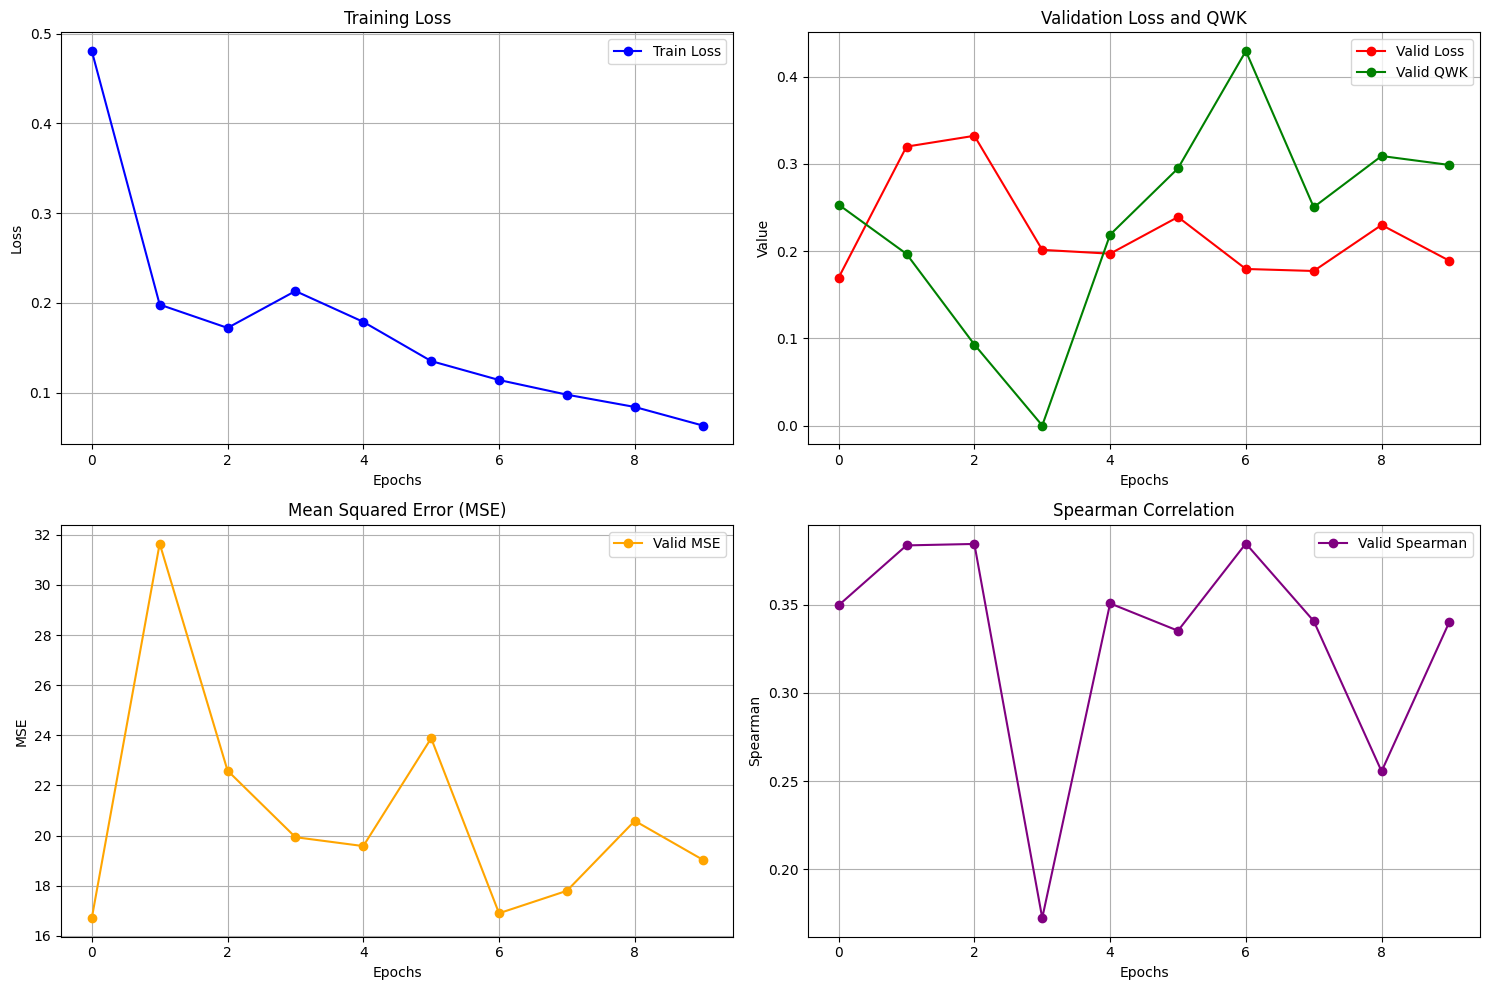

In [10]:

# Plot Training Loss
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(history_train_loss, label='Train Loss', color='blue', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Extract metrics for plotting
valid_loss = [m['loss'] for m in history_valid_metrics]
valid_qwk = [m['QWK'] for m in history_valid_metrics]
valid_mse = [m['MSE'] for m in history_valid_metrics]
valid_spearman = [m['Spearman'] for m in history_valid_metrics]
epochs_range = range(len(history_valid_metrics))

# Plot Validation Loss & QWK
plt.subplot(2, 2, 2)
plt.plot(epochs_range, valid_loss, label='Valid Loss', color='red', marker='o')
plt.plot(epochs_range, valid_qwk, label='Valid QWK', color='green', marker='o')
plt.title('Validation Loss and QWK')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Plot MSE
plt.subplot(2, 2, 3)
plt.plot(epochs_range, valid_mse, label='Valid MSE', color='orange', marker='o')
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

# Plot Spearman
plt.subplot(2, 2, 4)
plt.plot(epochs_range, valid_spearman, label='Valid Spearman', color='purple', marker='o')
plt.title('Spearman Correlation')
plt.xlabel('Epochs')
plt.ylabel('Spearman')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Test Evaluation

In [11]:
print("Loading best model for testing...")
model = BertForSequenceClassification.from_pretrained('./model_essay_regression_best')
model = model.to(device)

test_metrics, test_preds = eval_func(test_loader, model, device)
print(f"\nTest Metrics: {metrics_to_string(test_metrics)}")

Loading best model for testing...


Evaluation: 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


Test Metrics: loss:0.1874 MSE:16.3848 RMSE:4.0478 Pearson:0.5116 Spearman:0.5191 QWK:0.4966


In [12]:
# Sample Predictions
n_samples = 5
print("Sample Predictions:")
for i in range(n_samples):
    row = test_dataset.data.iloc[i]
    print(f"Question: {row['question']}")
    print(f"Answer: {row['answer']}")
    print(f"True Score: {row['score']}")
    print(f"Pred Score: {test_preds[i]:.2f}")
    print("-" * 30)

Sample Predictions:
Question: sebutkan tiga ciri khas hikayat sebagai karya sastra lama
Answer: mustahil istana sentris anonim menceritakan tentang tokoh pahalawan mengandung unsur metologi menyampaikan pesan moral
True Score: 10
Pred Score: 9.51
------------------------------
Question: sebutkan tiga ciri utama dari teks laporan hasil observasi
Answer: bersifat objektif data virtual dan menggunakan bahasa baku
True Score: 10
Pred Score: 9.50
------------------------------
Question: apa yang dimaksud dengan hikayat jelaskan dengan bahasamu sendiri
Answer: crita hikayat
True Score: 0
Pred Score: 0.00
------------------------------
Question: apa yang dimaksud dengan hikayat jelaskan dengan bahasamu sendiri
Answer: karya satsra lama mlayu berbentuk prosa yg berisi cerita
True Score: 10
Pred Score: 9.44
------------------------------
Question: sebutkan struktur teks anekdot dan jelaskan secara singkat setiap bagiannya
Answer: kalimat awal kalimat akhir yg ada pada teks anekdot
True Score: 0

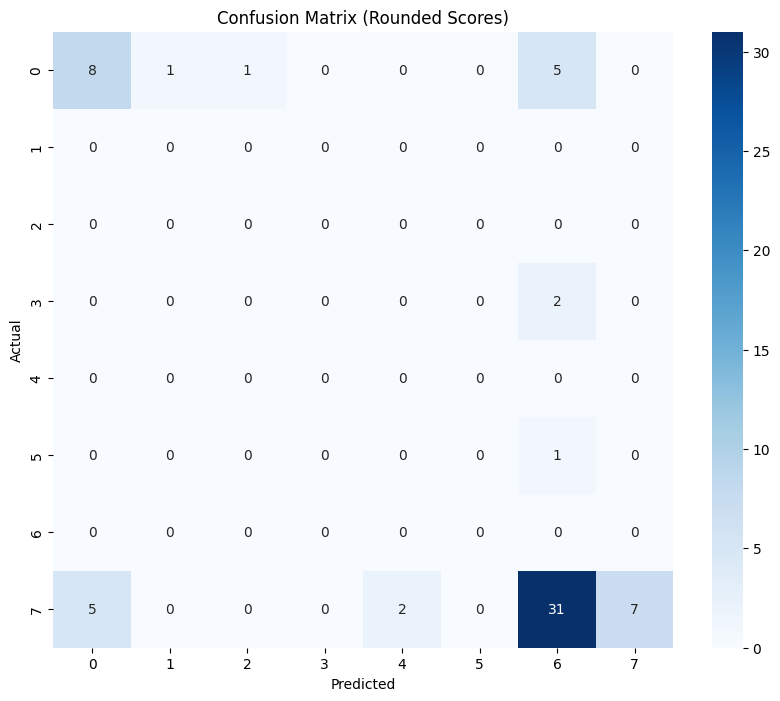

In [13]:
# Confusion Matrix for rounded predictions
all_preds_int = np.clip(np.round(test_preds), 0, 10).astype(int)
all_labels_int = np.round(test_dataset.data['score']).astype(int)

cm = confusion_matrix(all_labels_int, all_preds_int)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Rounded Scores)')
plt.show()